# Perform time series forecasting using XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error

from joblib import dump
from joblib import load

In [2]:
df = pd.read_csv("./data/Mastercard_stock_history.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
1,2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2,2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
3,2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
4,2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


Once again, we try to forecast the close price using previous date features, as well as generating new features for our model to predict the close price

In [3]:
# convert Date into datetime, and set the date as the index of the dataframe
df['Date'] = pd.to_datetime(df['Date'])
# set date as the index
df.set_index('Date', inplace=True)

df = df.asfreq("D")
df = df.interpolate() # interpolate data to remove NaN values

## Create new features for the model

We will create features for:

1. month
2. day of the week
3. moving average
4. moving standard deviation
5. previous days' lagged close prices
6. open price
7. quarter of the year
8. Relative Strength Indicator

In [4]:
df['month'] = df.index.month
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month
Date,,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000.0,0.0,0.0,5
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000.0,0.0,0.0,5
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5


In [5]:
df['day'] = df.index.day_of_week
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day
Date,,,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000.0,0.0,0.0,5,3
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000.0,0.0,0.0,5,4
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0


In [6]:
df['quarter'] = df.index.quarter
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day,quarter
Date,,,,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000.0,0.0,0.0,5,3,2
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000.0,0.0,0.0,5,4,2
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5,2
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6,2
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0,2


In [7]:
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)

df = df.dropna()
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day,quarter,lag_1,lag_2
Date,,,,,,,,,,,,
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5,2,4.179680,4.279217
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6,2,4.158051,4.179680
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0,2,4.136422,4.158051
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000.0,0.0,0.0,5,1,2,4.114793,4.136422
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000.0,0.0,0.0,5,2,2,4.093164,4.114793


In [8]:
# create RSI indicator
df['change'] = df['Close'].diff()
df['change'] = df['change'].shift(1) # lag the change column by 1 time step

df['gain'] = df['change'].apply(lambda x: x if x > 0 else 0)
df['loss'] = df['change'].apply(lambda x: -x if x < 0 else 0)

df['avg_gain'] = df['gain'].rolling(window = 30, min_periods = 1).mean()
df['avg_loss'] = df['loss'].rolling(window = 30, min_periods = 1).mean()

df['RSI'] = 100 - (100 / (1 + (df["avg_gain"] / df["avg_loss"])))
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day,quarter,lag_1,lag_2,change,gain,loss,avg_gain,avg_loss,RSI
Date,,,,,,,,,,,,,,,,,,
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5,2,4.179680,4.279217,NaN,0.0,0.000000,0.0,0.000000,NaN
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6,2,4.158051,4.179680,NaN,0.0,0.000000,0.0,0.000000,NaN
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0,2,4.136422,4.158051,-0.021629,0.0,0.021629,0.0,0.007210,0.0
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000.0,0.0,0.0,5,1,2,4.114793,4.136422,-0.021629,0.0,0.021629,0.0,0.010814,0.0
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000.0,0.0,0.0,5,2,2,4.093164,4.114793,-0.021629,0.0,0.021629,0.0,0.012977,0.0


In [9]:
# add ARBR with n = 6, non-lagged
def compute_arbr(df: pd.DataFrame, n = 6, in_place=False, include_lagged=True):
  if not in_place:
    df = df.copy()

  sum_high_open_diff = (df["High"] - df["Open"]).rolling(window=n, min_periods=1).sum()
  sum_open_low_diff = (df["Open"] - df["Low"]).rolling(window=n, min_periods=1).sum()
  df['AR'] = 100 * (sum_high_open_diff / sum_open_low_diff)

  lag_1_close = df["Close"].shift(1)
  max_high_close_diff = (df['High'] - lag_1_close).apply(lambda v: max(0, v))
  max_close_low_diff = (lag_1_close - df['Low']).apply(lambda v: max(0, v))
  df['BR'] = 100 * (max_high_close_diff.rolling(window=n, min_periods=1).sum()
                    / max_close_low_diff.rolling(window=n, min_periods=1).sum())
  if include_lagged:
    df['AR-LAG1'] = df['AR'].shift(1)
    df['BR-LAG1'] = df['BR'].shift(1)

  return df

# add MACD columns (MACD, DEA, MACD-DEA), non-lagged
def compute_macd(df: pd.DataFrame, in_place=False, include_lagged=True):
  ema_12 = df["Close"].ewm(span=12, adjust=False).mean()
  ema_26 = df["Close"].ewm(span=26, adjust=False).mean()
  macd= ema_26 - ema_12
  dea = macd.ewm(span=9, adjust=False).mean()
  df_cp = df

  if not in_place:
    df_cp = df.copy()

  df_cp['DEA'] = dea
  df_cp['MACD'] = macd
  df_cp['MACD-DEA'] = macd - dea
  if include_lagged:
    df_cp['DEA-LAG1'] = df_cp['DEA'].shift(1)
    df_cp['MACD-LAG1'] = df_cp['MACD'].shift(1)
    df_cp['MACD-DEA-LAG1'] = df_cp['MACD-DEA'].shift(1)

  return df_cp 

df_arbr = compute_arbr(df)
df_macd = compute_macd(df_arbr)

df_macd = df_macd.dropna()

# robust scaling on these features: rmse = 7.92
df = df_macd
df_macd[:7]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day,quarter,...,AR,BR,AR-LAG1,BR-LAG1,DEA,MACD,MACD-DEA,DEA-LAG1,MACD-LAG1,MACD-DEA-LAG1
Date,,,,,,,,,,,,,,,,,,,,,
2006-05-29,4.214332,4.225262,4.015487,4.114793,6.318450e+07,0.0,0.0,5,0,2,...,10.440726,84.110692,12.882599,95.481925,0.001233,0.004783,0.003550,0.000345,0.001725,0.001380
2006-05-30,4.183400,4.184330,3.986184,4.093164,4.989800e+07,0.0,0.0,5,1,2,...,7.978942,73.461091,10.440726,84.110692,0.002756,0.008849,0.006093,0.001233,0.004783,0.003550
2006-05-31,4.125723,4.219679,4.125723,4.180608,3.000200e+07,0.0,0.0,5,2,2,...,19.743606,108.332421,7.978942,73.461091,0.003197,0.004959,0.001762,0.002756,0.008849,0.006093
2006-06-01,4.179678,4.474572,4.176887,4.419686,6.234400e+07,0.0,0.0,6,3,2,...,56.471040,187.435339,19.743606,108.332421,-0.000886,-0.017218,-0.016331,0.003197,0.004959,0.001762
2006-06-02,4.511782,4.530387,4.352707,4.371312,3.725300e+07,0.0,0.0,6,4,2,...,58.049489,184.011592,56.471040,187.435339,-0.006817,-0.030537,-0.023721,-0.000886,-0.017218,-0.016331
2006-06-03,4.466820,4.547443,4.359219,4.438292,3.723133e+07,0.0,0.0,6,5,2,...,75.119224,260.484081,58.049489,184.011592,-0.014647,-0.045968,-0.031321,-0.006817,-0.030537,-0.023721
2006-06-04,4.421858,4.564498,4.365731,4.505271,3.720967e+07,0.0,0.0,6,6,2,...,120.818332,318.017817,75.119224,260.484081,-0.024293,-0.062877,-0.038584,-0.014647,-0.045968,-0.031321


In [10]:
# create lag-1 30 day rolling mean and standard deviations
df['MA'] = df["lag_1"].rolling(30).mean()
df['M_STD'] = df["lag_1"].rolling(30).std()

df = df.dropna() # remove NaNs after rolling functions have been applied

In [11]:
columns_to_keep = ["Open", "Volume", "Close", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD"] # ignore RSI, since it makes predictions worse
df1 = df[columns_to_keep]
df1.head()

,Open,Volume,Close,month,day,quarter,lag_1,lag_2,MA,M_STD
Date,,,,,,,,,,
2006-06-27,4.418758,9.826000e+06,4.401083,6,1,2,4.418758,4.401703,4.312141,0.141078
2006-06-28,4.358291,8.756000e+06,4.368524,6,2,2,4.401083,4.418758,4.320963,0.137951
2006-06-29,4.367592,1.447000e+07,4.465270,6,3,2,4.368524,4.401083,4.329421,0.132547
2006-06-30,4.432710,2.596400e+07,4.465270,6,4,2,4.465270,4.368524,4.341824,0.126970
2006-07-01,4.440462,1.965233e+07,4.443563,7,5,3,4.465270,4.465270,4.351313,0.125130


## Standardize the data

In [12]:
scaler = StandardScaler()
robust_scaler = RobustScaler()
cols_to_standardize = ['Open', "Volume", "lag_1", "lag_2", "MA", "M_STD"]
df_scaled = df1.copy()
df_scaled[cols_to_standardize] = scaler.fit_transform(df1[cols_to_standardize])
# cols_to_scale = ['AR', 'BR', "RSI"]
# df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])
df_scaled.head()

,Open,Volume,Close,month,day,quarter,lag_1,lag_2,MA,M_STD
Date,,,,,,,,,,
2006-06-27,-0.951161,-0.131355,4.401083,6,1,2,-0.951419,-0.951372,-0.950331,-0.686196
2006-06-28,-0.951730,-0.199198,4.368524,6,2,2,-0.951586,-0.951211,-0.950248,-0.687036
2006-06-29,-0.951643,0.163099,4.465270,6,3,2,-0.951892,-0.951378,-0.950168,-0.688487
2006-06-30,-0.951030,0.891878,4.465270,6,4,2,-0.950981,-0.951685,-0.950050,-0.689985
2006-07-01,-0.950957,0.491686,4.443563,7,5,3,-0.950981,-0.950773,-0.949960,-0.690480


## Modelling

In [13]:
# split data into last 20 days to predict as test data
df_train = df1.iloc[:-100]
df_test = df1.iloc[-100:]

X_train = df_train[["Open", "Volume", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD"]]
# X_train = df_train[["Open", "Volume", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD", "RSI", "AR", "BR"]][:-1]
y_train = df_train[["Close"]]
X_test = df_test[["Open", "Volume", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD"]]
# X_test = df_test[["Open", "Volume", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD", "RSI", "AR", "BR"]][:-1]
y_test = df_test[["Close"]]

In [14]:
model = XGBRegressor(objective = "reg:squarederror")
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Root mean squared error is: {np.sqrt(mse) : .2f}")

Root mean squared error is:  5.54


In [16]:
y_pred

array([375.61017, 372.6563 , 372.90063, 372.0116 , 370.2804 , 368.37006,
       371.34293, 371.4102 , 376.0503 , 371.02332, 383.0797 , 381.6673 ,
       378.93787, 381.7053 , 380.32364, 364.13553, 365.7043 , 373.10123,
       376.73206, 379.2348 , 379.40402, 380.35333, 380.95367, 380.2255 ,
       377.3852 , 384.31537, 380.0724 , 379.7698 , 380.08115, 380.19272,
       374.93835, 365.2128 , 368.71283, 370.08658, 376.20267, 369.88013,
       369.8596 , 369.56204, 365.57428, 368.69894, 363.4271 , 363.42578,
       363.13345, 360.6068 , 361.82117, 359.61722, 361.8132 , 359.2221 ,
       355.03955, 355.60202, 363.1261 , 362.5519 , 364.22522, 359.62042,
       359.579  , 360.0011 , 358.76364, 351.69916, 352.99017, 341.95648,
       350.84344, 337.28738, 338.47443, 340.76218, 343.8516 , 344.2925 ,
       344.8353 , 354.00272, 354.36548, 352.1394 , 352.88647, 354.58484,
       353.96658, 343.14725, 343.76453, 339.124  , 341.3389 , 337.39038,
       336.80673, 339.002  , 337.43558, 340.58517, 

Plot the predicted and actual data

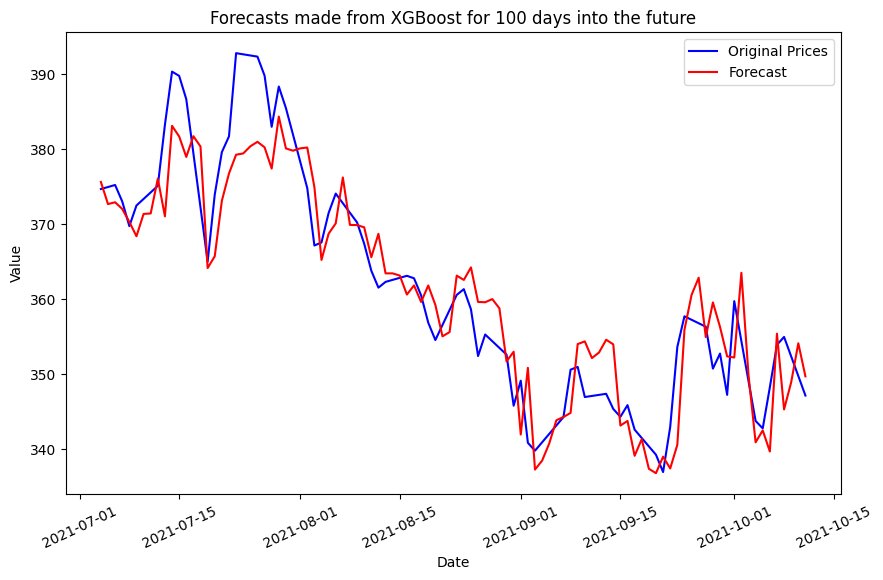

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label = "Original Prices", color = "blue")
plt.plot(X_test.index, y_pred, label = "Forecast", color = "red")

# Add labels and title
plt.title("Forecasts made from XGBoost for 100 days into the future")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation = 25)
plt.legend()

# Show the plot
plt.show()

We can see that the XGBoost model is much better at predicting the time series compared to ARIMA in the modelling notebook, as we get a much lower MSE

## Save the model

In [18]:
dump(model, "./models/XGBRegressor.pkl")

['./models/XGBRegressor.pkl']

In [19]:
# test loading of model
test_model = load("./models/XGBRegressor.pkl")

In [20]:
test_model.predict(X_test)

array([375.61017, 372.6563 , 372.90063, 372.0116 , 370.2804 , 368.37006,
       371.34293, 371.4102 , 376.0503 , 371.02332, 383.0797 , 381.6673 ,
       378.93787, 381.7053 , 380.32364, 364.13553, 365.7043 , 373.10123,
       376.73206, 379.2348 , 379.40402, 380.35333, 380.95367, 380.2255 ,
       377.3852 , 384.31537, 380.0724 , 379.7698 , 380.08115, 380.19272,
       374.93835, 365.2128 , 368.71283, 370.08658, 376.20267, 369.88013,
       369.8596 , 369.56204, 365.57428, 368.69894, 363.4271 , 363.42578,
       363.13345, 360.6068 , 361.82117, 359.61722, 361.8132 , 359.2221 ,
       355.03955, 355.60202, 363.1261 , 362.5519 , 364.22522, 359.62042,
       359.579  , 360.0011 , 358.76364, 351.69916, 352.99017, 341.95648,
       350.84344, 337.28738, 338.47443, 340.76218, 343.8516 , 344.2925 ,
       344.8353 , 354.00272, 354.36548, 352.1394 , 352.88647, 354.58484,
       353.96658, 343.14725, 343.76453, 339.124  , 341.3389 , 337.39038,
       336.80673, 339.002  , 337.43558, 340.58517, 

Our model can be saved and loaded successfully.

## Tune the XGB model

In [21]:
search_space = {
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
    'min_split_loss': [2, 5, 10, 20, 30],
    'max_depth': [5, 10, 15, 20, 30],
    'reg_lambda': [1, 2, 5, 10],
    'reg_alpha': [1, 2, 3, 10]
}

best_params = {
    "eta": 0,
    "min_split_loss": 0,
    "max_depth": 0,
    "reg_lambda": 0,
    "reg_alpha": 0
}

best_model = XGBRegressor(random_state = 42)

best_rmse = 10000000

scores = []

i = 0
j = 0
stop = False

for e in search_space['eta']:
    if stop: break
    for sl in search_space['min_split_loss']:
        if stop: break
        for max_d in search_space['max_depth']:
            if stop: break
            for l in search_space['reg_lambda']:
                if stop: break
                for alpha in search_space['reg_alpha']:
                    model = XGBRegressor(
                        objective = "reg:squarederror",
                        eta = e,
                        min_split_loss = sl,
                        max_depth = max_d,
                        reg_lambda = l,
                        reg_alpha = alpha,
                        random_state = 42
                    )

                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)

                    scores.append(np.sqrt(mse))

                    # update parameters if get better RMSE
                    if np.sqrt(mse) < best_rmse:
                        print(f"New best RMSE of validation set is: {np.sqrt(mse)}")
                        best_rmse = np.sqrt(mse)
                        best_params['eta'] = e
                        best_params['min_split_loss'] = sl
                        best_params['max_depth'] = max_d
                        best_params['reg_lambda'] = l
                        best_params['reg_alpha'] = alpha

                        print(best_params)

                        best_model = model

                    # implement early stopping if after 10 rounds, no more significant improvements in rmse
                    if len(scores) > 1 and (scores[i] > scores[i - 1] or abs(scores[i] - scores[i - 1]) < 0.1):
                        j += 1
                    else:
                        j = 0

                    if j == 10:
                        stop = True
                        break
                    
                    i += 1

New best RMSE of validation set is: 4.971776030569454
{'eta': 0.1, 'min_split_loss': 2, 'max_depth': 5, 'reg_lambda': 1, 'reg_alpha': 1}
New best RMSE of validation set is: 4.948973715128027
{'eta': 0.1, 'min_split_loss': 2, 'max_depth': 5, 'reg_lambda': 1, 'reg_alpha': 10}
New best RMSE of validation set is: 4.839359135372994
{'eta': 0.1, 'min_split_loss': 5, 'max_depth': 5, 'reg_lambda': 1, 'reg_alpha': 1}


In [22]:
best_params

{'eta': 0.1,
 'min_split_loss': 5,
 'max_depth': 5,
 'reg_lambda': 1,
 'reg_alpha': 1}

In [23]:
best_model = XGBRegressor(
    random_state = 42,
    **best_params
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Best root mean squared error is: {np.sqrt(mse) : .2f}")

Best root mean squared error is:  4.84


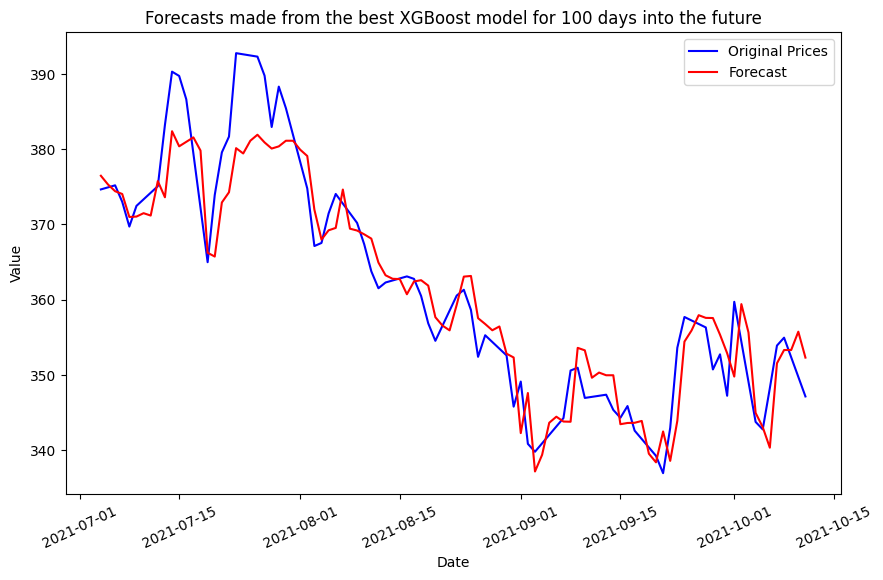

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label = "Original Prices", color = "blue")
plt.plot(X_test.index, y_pred, label = "Forecast", color = "red")

# Add labels and title
plt.title("Forecasts made from the best XGBoost model for 100 days into the future")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation = 25)
plt.legend()

# Show the plot
plt.show()

## Save the best XGB model

In [25]:
dump(best_model, "./models/best_XGBRegressor.pkl")

['./models/best_XGBRegressor.pkl']